In [104]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from ase.build import graphene
from ase.dft.kpoints import sc_special_points as special_points, get_bandpath
import pyscf.pbc.gto as pbcgto
import pyscf.pbc.dft as pbcdft
import pyscf.pbc.tools.pyscf_ase as pyscf_ase

# Function to apply strain to the graphene unit cell
def apply_strain_to_graphene(graphene_structure, strain_x=0.0, strain_y=0.0):
    """
    Apply strain to the graphene unit cell by scaling the lattice vectors.
    
    Parameters:
    - graphene_structure: ASE Atoms object of graphene.
    - strain_x: Strain applied in the x-direction (percentage).
    - strain_y: Strain applied in the y-direction (percentage).
    
    Returns:
    - strained_structure: The strained graphene structure.
    """
    # Copy the original lattice vectors
    strained_cell = graphene_structure.cell.copy()

    # Apply strain to the lattice vectors
    strained_cell[0, 0] *= (1 + strain_x)  # Apply strain in the x-direction
    strained_cell[1, 1] *= (1 + strain_y)  # Apply strain in the y-direction

    # Create a new structure with the strained lattice
    strained_structure = graphene_structure.copy()
    strained_structure.set_cell(strained_cell, scale_atoms=True)

    return strained_structure

# Function to plot the graphene lattice with strain
def plot_graphene_lattice(graphene_structure, strained_structure, n_cells_x=5, n_cells_y=5, title="Graphene Lattice with Strain"):
    """
    Plot the graphene lattice with strain applied by repeating the unit cell.
    
    Parameters:
    - graphene_structure: Original unstrained graphene structure.
    - strained_structure: The strained graphene structure.
    - n_cells_x: Number of unit cells in the x-direction.
    - n_cells_y: Number of unit cells in the y-direction.
    - title: Title of the plot.
    """
    # Extract atomic positions and unit cell vectors
    positions_original = graphene_structure.positions
    positions_strained = strained_structure.positions
    cell_original = graphene_structure.cell[:2]  # Only take 2D lattice vectors for plotting
    cell_strained = strained_structure.cell[:2]
    
    # Generate the full lattice by replicating the unit cell
    full_positions_original = []
    full_positions_strained = []
    
    for i in range(n_cells_x):
        for j in range(n_cells_y):
            # Shift the positions of the atoms by the translation vectors of the lattice
            shifted_positions_original = positions_original + np.array([i, j]) @ cell_original
            full_positions_original.append(shifted_positions_original)
            
            shifted_positions_strained = positions_strained + np.array([i, j]) @ cell_strained
            full_positions_strained.append(shifted_positions_strained)
    
    # Convert full positions into a single array
    full_positions_original = np.vstack(full_positions_original)
    full_positions_strained = np.vstack(full_positions_strained)
    
    # Plot the full lattice (original and strained)
    plt.figure(figsize=(6, 6))
    plt.scatter(full_positions_original[:, 0], full_positions_original[:, 1], color='black', label="Original Carbon Atoms", s=40)
    plt.scatter(full_positions_strained[:, 0], full_positions_strained[:, 1], color='red', label="Strained Carbon Atoms", s=40)

    # Add lattice visualization (repeated unit cells)
    origin = [0, 0]
    for vector in cell_original:
        plt.quiver(*origin, *vector[:2], angles='xy', scale_units='xy', scale=1, color='blue', linewidth=1.5, label="Original Lattice Vector")
    for vector in cell_strained:
        plt.quiver(*origin, *vector[:2], angles='xy', scale_units='xy', scale=1, color='green', linewidth=1.5, label="Strained Lattice Vector")

    # Add labels, legend, and grid
    plt.xlabel('x (Å)')
    plt.ylabel('y (Å)')
    plt.title(title)
    plt.axis('equal')
    plt.grid(True)
    plt.legend()
    plt.show()



Graphene unit cell volume: 104.8167866708382 Å³


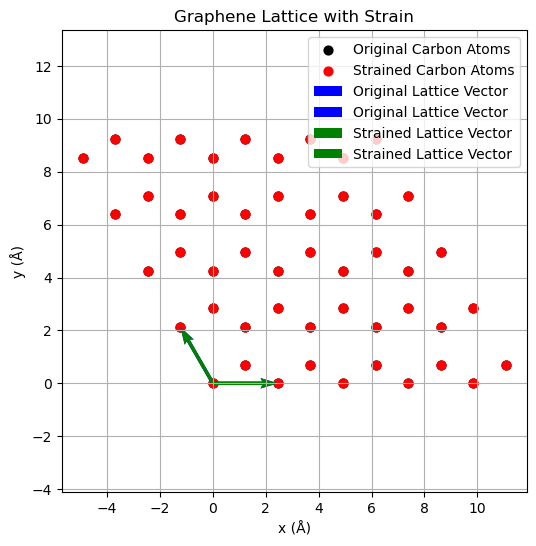

In [224]:
# Create graphene structure
graphene_structure = graphene(vacuum=10.0)  # Single-layer graphene with vacuum in z-direction
print(f"Graphene unit cell volume: {graphene_structure.get_volume()} Å³")

# Apply strain to the graphene structure (e.g., x% strain in the x-direction)
strained_structure = apply_strain_to_graphene(graphene_structure, strain_x=0.00, strain_y=0.00)

# Plot the original and strained graphene lattice
plot_graphene_lattice(graphene_structure, strained_structure)

# Initialize PySCF periodic cell for strained graphene
cell = pbcgto.Cell()
cell.atom = pyscf_ase.ase_atoms_to_pyscf(strained_structure)
cell.a = strained_structure.cell  # Lattice vectors

cell.basis = 'gth-szv'
cell.pseudo = 'gth-pade'
cell.verbose = 5
cell.build(None, None)



In [225]:
# Define k-points and band structure path for hexagonal lattice (graphene)
points = special_points['hexagonal']
G = points['G']
M = points['M']
K = points['K']
# K1= [1 / 6, 1 / 6, 0]
# K2= [5 / 12, 1 / 6, 0]
# 'hexagonal': {'G': [0, 0, 0],
#                   'A': [0, 0, 1 / 2],
#                   'H': [1 / 3, 1 / 3, 1 / 2],
#                   'K': [1 / 3, 1 / 3, 0],
#                   'L': [1 / 2, 0, 1 / 2],
#                   'M': [1 / 2, 0, 0]}}
band_kpts, kpath, sp_points = get_bandpath([G, K, M, G], strained_structure.cell, npoints=50)
band_kpts = cell.get_abs_kpts(band_kpts)

# Band structure from Gamma point sampling
mf = pbcdft.RKS(cell)
print(mf.kernel())

e_kn = mf.get_bands(band_kpts)[0]
vbmax = -99
for en in e_kn:
    vb_k = en[cell.nelectron // 2 - 1]
    if vb_k > vbmax:
        vbmax = vb_k
e_kn = [en - vbmax for en in e_kn]

# Band structure from 222 k-point sampling
kmf = pbcdft.KRKS(cell, cell.make_kpts([2, 2, 2]))
print(kmf.kernel())

e_kn_2 = kmf.get_bands(band_kpts)[0]
vbmax = -99
for en in e_kn_2:
    vb_k = en[cell.nelectron // 2 - 1]
    if vb_k > vbmax:
        vbmax = vb_k
e_kn_2 = [en - vbmax for en in e_kn_2]





******** <class 'pyscf.pbc.dft.rks.RKS'> ********
method = RKS
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
diis_damp = 0
SCF conv_tol = 1e-07
SCF conv_tol_grad = None
SCF max_cycles = 50
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /tmp/tmp6x7_0bqs
max_memory 4000 MB (current use 949 MB)
******** PBC SCF flags ********
kpt = [0. 0. 0.]
Exchange divergence treatment (exxdiv) = ewald
Ewald components = 0.017886015064508, -0.208797500090022, 0.795105828268166
    madelung (= occupied orbital energy shift) = -1.2083886864853048
    Total energy shift due to Ewald probe charge = -1/2 * Nelec*madelung = 4.83355474594
DF object = <pyscf.pbc.df.fft.FFTDF object at 0x7f11eb7ff7f0>
XC functionals = LDA,VWN
small_rho_cutoff = 1e-07
Uniform grid, mesh = [ 45  45 351]
Set gradient conv threshold to 0.000316228
Initial guess from minao.
Big error detected in the electron number of

/home/xhliu/anaconda3/envs/finalenv/lib/python3.10/site-packages/ase/dft/kpoints.py:405: UserWarning: Please do not use (kpts, x, X) = bandpath(...).  Use path = bandpath(...) and then kpts = path.kpts and (x, X, labels) = path.get_linear_kpoint_axis().
  warnings.warn('Please do not use (kpts, x, X) = bandpath(...).  '


nelec by numeric integration = 7.99999999874516
    CPU time for vxc      9.57 sec, wall time      0.65 sec
Building PBC AO integrals incore
    CPU time for vj and vk     16.70 sec, wall time      1.45 sec
Ewald components = 4.32069005593024, -7.31468693743995, 50.8561890478015
E1 = -111.03250537303903  Ecoul = 54.17333531251202  Exc = -3.185320721136421
init E= -12.1822986153716
    CPU time for initialize scf     43.13 sec, wall time      3.36 sec
  HOMO = -0.571613056269398  LUMO = -0.113088771624798
  mo_energy =
[-1.10057575 -0.605655   -0.605655   -0.57161306 -0.11308877 -0.11308877
 -0.0232757   0.12028326]


/home/xhliu/anaconda3/envs/finalenv/lib/python3.10/site-packages/pyscf/pbc/gto/cell.py:127: UserWarning: Function cell.dumps drops attribute a because it is not JSON-serializable
  warnings.warn(msg)


nelec by numeric integration = 7.999999999458945
    CPU time for vxc      7.36 sec, wall time      0.50 sec
    CPU time for vj and vk      0.00 sec, wall time      0.00 sec
E1 = -110.76830932706709  Ecoul = 55.235793975898346  Exc = -3.366372721201502
cycle= 1 E= -11.0366959060784  delta_E= 1.15  |g|= 3.33e-13  |ddm|= 3.95
    CPU time for cycle= 1      7.66 sec, wall time      0.52 sec
  HOMO = -0.430109077516094  LUMO = 0.0552780114941856
  mo_energy =
[-0.981747   -0.50830057 -0.43010908 -0.43010908  0.05527801  0.05527801
  0.12894293  0.27498668]
nelec by numeric integration = 7.999999999458947
    CPU time for vxc      7.11 sec, wall time      0.48 sec
    CPU time for vj and vk      0.02 sec, wall time      0.00 sec
E1 = -110.7683093270671  Ecoul = 55.23579397589836  Exc = -3.366372721201503
cycle= 2 E= -11.0366959060784  delta_E=    0  |g|= 4.19e-13  |ddm|= 1.49e-12
    CPU time for cycle= 2      7.51 sec, wall time      0.51 sec
  HOMO = -0.430109077516091  LUMO = 0.05527801

In [227]:
# Save the band energies to a .npz file
def save_dft_data(e_kn, e_kn_2, filename="dft_data.npz"):
    # Save both arrays to a .npz file
    np.savez(filename, e_kn=e_kn, e_kn_2=e_kn_2)
    print(f"DFT data saved to {filename}")

# Example usage
save_dft_data(e_kn, e_kn_2, filename="dft_data_y0.00.npz")

DFT data saved to dft_data_y0.00.npz


In [228]:
# Load the saved DFT data from a .npz file
def load_dft_data(filename="dft_data_y0.00.npz"):
    data = np.load(filename)
    e_kn = data['e_kn']
    e_kn_2 = data['e_kn_2']
    print(f"DFT data loaded from {filename}")
    return e_kn, e_kn_2

# Example usage
e_kn, e_kn_2 = load_dft_data()


DFT data loaded from dft_data_y0.00.npz


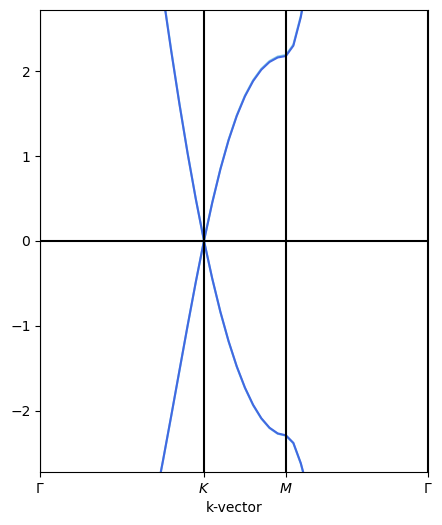

In [226]:
# Plot band structure
au2ev = 27.21139

emin = -0.1 * au2ev
emax = 0.1 * au2ev

plt.figure(figsize=(5, 6))
nbands = cell.nao_nr()
for n in range(nbands):
    plt.plot(kpath, [e[n] * au2ev for e in e_kn], color='#87CEEB')
    plt.plot(kpath, [e[n] * au2ev for e in e_kn_2], color='#4169E1')
for p in sp_points:
    plt.plot([p, p], [emin, emax], 'k-')
plt.plot([0, sp_points[-1]], [0, 0], 'k-')
plt.xticks(sp_points, ['$%s$' % n for n in ['Γ', 'K', 'M', 'Γ']])
plt.axis(xmin=0, xmax=sp_points[-1], ymin=emin, ymax=emax)
plt.xlabel('k-vector')

plt.show()


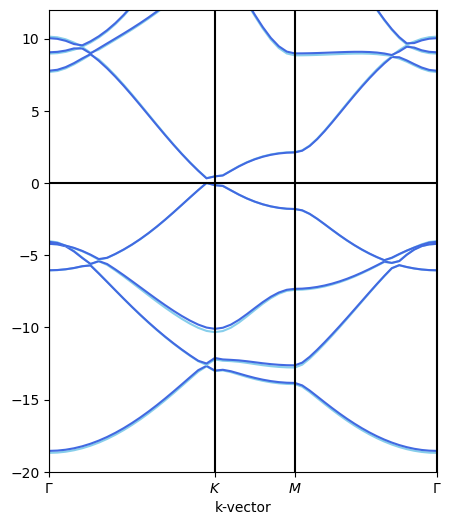

In [174]:
# Plot band structure
au2ev = 27.21139

emin = -20
emax = 12

plt.figure(figsize=(5, 6))
nbands = cell.nao_nr()
for n in range(nbands):
    plt.plot(kpath, [e[n] * au2ev for e in e_kn], color='#87CEEB')
    plt.plot(kpath, [e[n] * au2ev for e in e_kn_2], color='#4169E1')
for p in sp_points:
    plt.plot([p, p], [emin, emax], 'k-')
plt.plot([0, sp_points[-1]], [0, 0], 'k-')
plt.xticks(sp_points, ['$%s$' % n for n in ['Γ', 'K', 'M', 'Γ']])
plt.axis(xmin=0, xmax=sp_points[-1], ymin=emin, ymax=emax)
plt.xlabel('k-vector')

plt.show()


In [ ]:
import numpy as np

# Save the band energies to a .npz file
def save_dft_data(e_kn, e_kn_2, filename="dft_data_y0.00.npz"):
    # Save both arrays to a .npz file
    np.savez(filename, e_kn=e_kn, e_kn_2=e_kn_2)
    print(f"DFT data saved to {filename}")

# Example usage
save_dft_data(e_kn, e_kn_2)


In [273]:
# Load the saved DFT data from a .npz file
def load_dft_data(filename="dft_data_y-0.05.npz"):
    data = np.load(filename)
    e_kn = data['e_kn']
    e_kn_2 = data['e_kn_2']
    print(f"DFT data loaded from {filename}")
    return e_kn, e_kn_2

# Example usage
e_kn, e_kn_2 = load_dft_data()


DFT data loaded from dft_data_y-0.05.npz


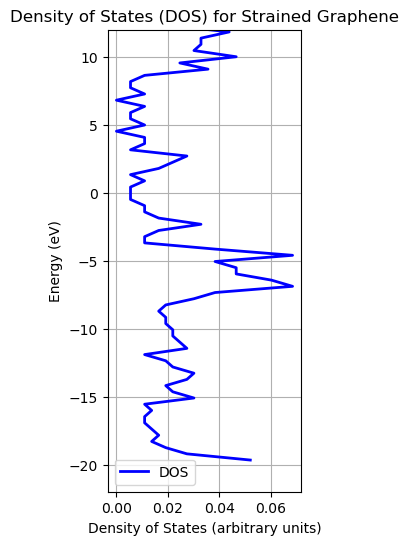

In [274]:
import numpy as np
import matplotlib.pyplot as plt

# Convert the band energies to eV for the DOS plot
def calculate_dos(e_kn, e_kn_2, au2ev=27.21139):
    """
    Calculate the Density of States (DOS) from band energies.
    Arguments:
    - e_kn: List of band energies (from DFT calculation).
    - e_kn_2: List of band energies (from the 222 k-point sampling).
    - au2ev: Conversion factor from Hartree to eV.
    Returns:
    - energies: Energy values for the DOS plot.
    - dos: Density of States (DOS) values.
    """
    # Flatten the band energies from both the Gamma-point and 222 k-point sampling
    band_energies = np.concatenate([np.array(e_kn), np.array(e_kn_2)], axis=1)
    
    # Convert energies to eV
    band_energies_ev = band_energies * au2ev
    
    # Flatten the band energies for histogram calculation
    all_energies = band_energies_ev.flatten()

    # Create bins for the energy axis
    energy_bins = np.linspace(np.min(all_energies), np.max(all_energies), 100)

    # Calculate the histogram and normalize it to create DOS
    dos, _ = np.histogram(all_energies, bins=energy_bins, density=True)

    # Plot the DOS with energy on the y-axis
    plt.figure(figsize=(2.5, 6))
    plt.plot(dos, energy_bins[:-1], color='blue', label="DOS", lw=2)  # Horizontal plot with energies on the y-axis
    plt.xlabel('Density of States (arbitrary units)')
    plt.ylabel('Energy (eV)')
    plt.title('Density of States (DOS) for Strained Graphene')
    plt.legend()
    plt.grid(True)
    plt.ylim([-22, 12])  # Set the y-axis limits for energy
    plt.show()

# Calculate and plot the DOS for strained graphene
calculate_dos(e_kn, e_kn_2)


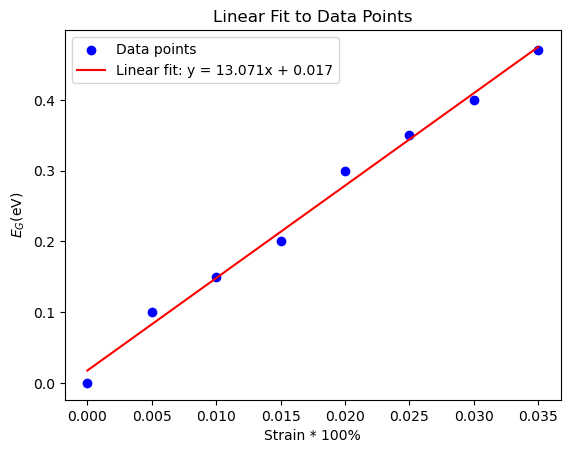

In [123]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Data points (x, y)
x = np.array([0.000, 0.005, 0.010, 0.015, 0.020, 0.025, 0.030, 0.035])
y = np.array([0.000, 0.100, 0.150, 0.200, 0.300, 0.350, 0.400, 0.470])

# Perform linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Plot data points
plt.scatter(x, y, color='blue', label='Data points')

# Plot the linear fit
plt.plot(x, slope * x + intercept, color='red', label=f'Linear fit: y = {slope:.3f}x + {intercept:.3f}')

# Labels and title
plt.xlabel('Strain * 100%')
plt.ylabel('$E_{G}$(eV)')
plt.title('Linear Fit to Data Points')
plt.legend()

# Show plot
plt.show()


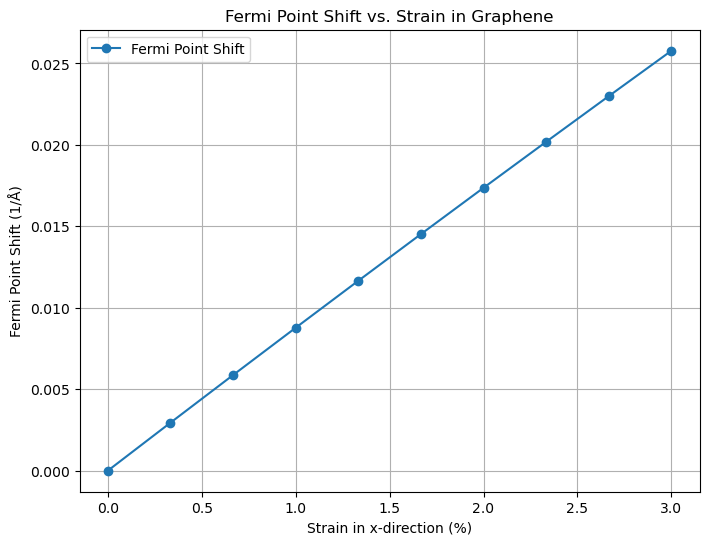

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from ase.build import graphene

def apply_strain_to_graphene(graphene_structure, strain_x=0.00, poisson_ratio=0.165):
    """Apply strain to graphene, considering the Poisson effect."""
    strained_lattice = graphene_structure.cell.copy()
    strained_lattice[0, 0] *= (1 + strain_x)  # Strain in x-direction
    strained_lattice[1, 1] *= (1 - strain_x * poisson_ratio)  # Shrink in y-direction
    strained_structure = graphene_structure.copy()
    strained_structure.set_cell(strained_lattice, scale_atoms=True)
    return strained_structure

# Reciprocal lattice calculation
def reciprocal_lattice(direct_lattice):
    """Calculate the reciprocal lattice vectors from the direct lattice."""
    a1, a2, a3 = direct_lattice
    volume = np.dot(a1, np.cross(a2, a3))
    b1 = 2 * np.pi * np.cross(a2, a3) / volume
    b2 = 2 * np.pi * np.cross(a3, a1) / volume
    b3 = 2 * np.pi * np.cross(a1, a2) / volume
    return np.array([b1, b2, b3])

# Initialize graphene
graphene_structure = graphene(vacuum=10.0)  # Single-layer graphene with vacuum in z-direction

# Initialize strain parameters
strain_values = np.linspace(0, 0.03, 10)  # Strain from 0% to 3% in x-direction
poisson_ratio = 0.165  # Approximate Poisson ratio for graphene
fermi_shifts = []

# Original reciprocal lattice and Fermi points
original_reciprocal = reciprocal_lattice(graphene_structure.cell)
K_original = original_reciprocal[0] / 3 + original_reciprocal[1] / 3  # Example K-point

# Apply strain and compute new Fermi points
for strain_x in strain_values:
    strained_structure = apply_strain_to_graphene(graphene_structure, strain_x, poisson_ratio)
    strained_reciprocal = reciprocal_lattice(strained_structure.cell)
    K_strained = strained_reciprocal[0] / 3 + strained_reciprocal[1] / 3
    shift = K_strained - K_original
    fermi_shifts.append(np.linalg.norm(shift))

# Plot the Fermi point shifts
plt.figure(figsize=(8, 6))
plt.plot(strain_values * 100, fermi_shifts, marker='o', label='Fermi Point Shift')
plt.xlabel('Strain in x-direction (%)')
plt.ylabel('Fermi Point Shift (1/Å)')
plt.title('Fermi Point Shift vs. Strain in Graphene')
plt.grid(True)
plt.legend()
plt.show()


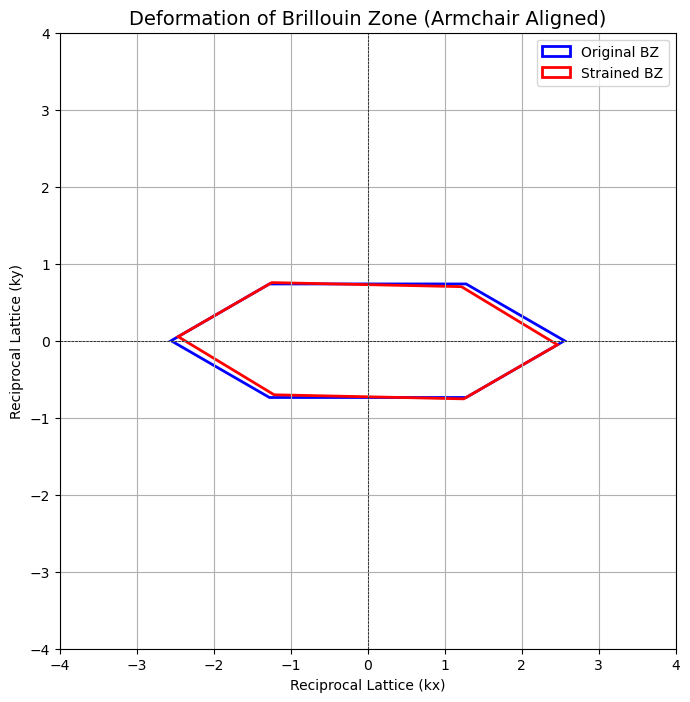

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ase.build import graphene
from matplotlib.patches import Polygon

def reciprocal_lattice(direct_lattice):
    """Calculate the reciprocal lattice vectors from the direct lattice."""
    a1, a2, a3 = direct_lattice
    volume = np.dot(a1, np.cross(a2, a3))
    b1 = 2 * np.pi * np.cross(a2, a3) / volume
    b2 = 2 * np.pi * np.cross(a3, a1) / volume
    b3 = 2 * np.pi * np.cross(a1, a2) / volume
    return np.array([b1, b2, b3])

def plot_bz(reciprocal_vectors, ax, label, color):
    """Plot the 2D Brillouin zone using reciprocal lattice vectors."""
    b1, b2, _ = reciprocal_vectors
    # Vertices of the hexagon in the xy-plane
    vertices = [
        0.5 * b1[:2],
        0.5 * b1[:2] + 0.5 * b2[:2],
        0.5 * b2[:2],
        -0.5 * b1[:2],
        -0.5 * b1[:2] - 0.5 * b2[:2],
        -0.5 * b2[:2],
        0.5 * b1[:2],  # Close the hexagon
    ]
    vertices = np.array(vertices)
    polygon = Polygon(vertices, closed=True, edgecolor=color, fill=False, linewidth=2, label=label)
    ax.add_patch(polygon)

# Generate graphene structure
graphene_structure = graphene(vacuum=10.0)
strained_structure = apply_strain_to_graphene(graphene_structure, strain_x=0.0, strain_y=0.05)  # Strain along y-axis

# Calculate reciprocal lattice vectors
original_reciprocal = reciprocal_lattice(graphene_structure.cell)
strained_reciprocal = reciprocal_lattice(strained_structure.cell)

# Adjust orientation: y-axis aligned along the armchair direction
def rotate_to_armchair(reciprocal_vectors):
    rotation_matrix = np.array([
        [np.cos(np.pi / 3), np.sin(np.pi / 3), 0],  # Rotate 30° clockwise
        [-np.sin(np.pi / 3), np.cos(np.pi / 3), 0],
        [0, 0, 1],
    ])
    return np.dot(reciprocal_vectors, rotation_matrix.T)

rotated_original_reciprocal = rotate_to_armchair(original_reciprocal)
rotated_strained_reciprocal = rotate_to_armchair(strained_reciprocal)

# Plot Brillouin zones
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect('equal')
plot_bz(rotated_original_reciprocal, ax, label='Original BZ', color='blue')
plot_bz(rotated_strained_reciprocal, ax, label='Strained BZ', color='red')

# Plot settings
ax.axhline(0, color='k', linewidth=0.5, linestyle='--')
ax.axvline(0, color='k', linewidth=0.5, linestyle='--')
ax.set_xlim([-4, 4])
ax.set_ylim([-4, 4])
ax.set_title('Deformation of Brillouin Zone (Armchair Aligned)', fontsize=14)
ax.legend()
plt.xlabel('Reciprocal Lattice (kx)')
plt.ylabel('Reciprocal Lattice (ky)')
plt.grid(True)
plt.show()


/tmp/ipykernel_85724/1820294270.py:74: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(coord[0], coord[1], 'ro', color='black')  # Mark point


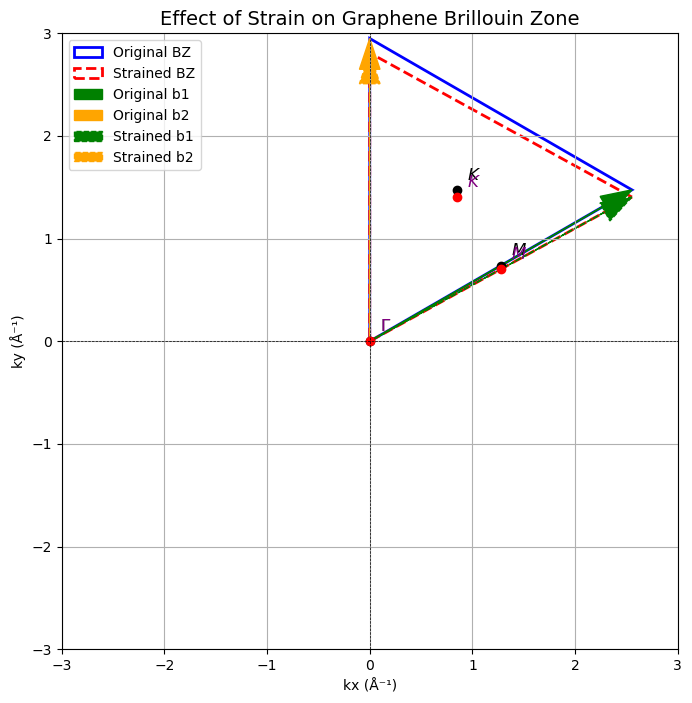

In [278]:
import numpy as np
import matplotlib.pyplot as plt
from ase.build import graphene
from matplotlib.patches import Polygon

def reciprocal_lattice(direct_lattice):
    """Calculate the reciprocal lattice vectors from the direct lattice."""
    a1, a2, a3 = direct_lattice
    volume = np.dot(a1, np.cross(a2, a3))
    b1 = 2 * np.pi * np.cross(a2, a3) / volume
    b2 = 2 * np.pi * np.cross(a3, a1) / volume
    b3 = 2 * np.pi * np.cross(a1, a2) / volume
    return np.array([b1, b2, b3])
# Generate graphene structure
graphene_structure = graphene(vacuum=10.0)
strained_structure = apply_strain_to_graphene(graphene_structure, strain_x=0.0, strain_y=0.05)  # Strain along y-axis

# Calculate reciprocal lattice vectors

def plot_brillouin_zone_with_strain(strain_x=0.0, strain_y=0.0):
    """Plot original and strained Brillouin zones of graphene with independent x and y strain."""
    a = 2.46  # Lattice constant in Å
    original_reciprocal = reciprocal_lattice(graphene_structure.cell)
    strained_reciprocal = reciprocal_lattice(strained_structure.cell)

    # Extract 2D components (kx, ky) by dropping the z-component
    def project_to_2d(vecs):
        return vecs[:, :2]

    original_vectors_2d = project_to_2d(original_reciprocal)
    strained_vectors_2d = project_to_2d(strained_reciprocal)

    # # Calculate vertices for original and strained Brillouin zones
    # def calculate_vertices(b1, b2):
    #     return np.array([
    #         0.5 * b1,
    #         0.5 * b1 + 0.5 * b2,
    #         0.5 * b2,
    #         -0.5 * b1,
    #         -0.5 * b1 - 0.5 * b2,
    #         -0.5 * b2,
    #         0.5 * b1
    #     ])

    # original_vertices = calculate_vertices(*original_vectors_2d)
    # strained_vertices = calculate_vertices(*strained_vectors_2d)
#  cell_original = graphene_structure.cell[:2]  # Only take 2D lattice vectors for plotting
#     cell_strained = strained_structure.cell[:2]
    # Plot the Brillouin zones
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot original Brillouin zone
    original_polygon = Polygon(original_vectors_2d, closed=True, edgecolor='blue', fill=False, linewidth=2, label="Original BZ")
    ax.add_patch(original_polygon)

    # Plot strained Brillouin zone
    strained_polygon = Polygon(strained_vectors_2d, closed=True, edgecolor='red', fill=False, linewidth=2, linestyle='--', label="Strained BZ")
    ax.add_patch(strained_polygon)

    # Plot high-symmetry points (for the original BZ only)
    high_symmetry_points = {
        r"$\Gamma$": [0, 0],
        r"$K$": (original_vectors_2d[0] + original_vectors_2d[1]) / 3,
        r"$M$": (original_vectors_2d[0] ) / 2
    }

#                   'G': [0, 0, 0],
#                   'A': [0, 0, 1 / 2],
#                   'H': [1 / 3, 1 / 3, 1 / 2],
#                   'K': [1 / 3, 1 / 3, 0],
#                   'L': [1 / 2, 0, 1 / 2],
#                   'M': [1 / 2, 0, 0]}}
    for label, coord in high_symmetry_points.items():
        ax.plot(coord[0], coord[1], 'ro', color='black')  # Mark point
        ax.text(coord[0] + 0.1, coord[1] + 0.1, label, fontsize=12)

    # Plot high-symmetry points 
    high_symmetry_points2 = {
        r"$\Gamma$": [0, 0],
        r"$K$": (strained_vectors_2d[0] + strained_vectors_2d[1]) / 3,
        r"$M$": (strained_vectors_2d[0] ) / 2
    }

    # for label, coord in high_symmetry_points2.items():
    #     ax.plot(coord[0], coord[1], 'ro')  # Mark point
    #     ax.text(coord[0] + 0.1, coord[1] + 0.1, label, fontsize=12)
    for label, coord in high_symmetry_points2.items():
        ax.plot(coord[0], coord[1], marker='o', color='red')  # Mark point with green color
        ax.text(coord[0] + 0.1, coord[1] + 0.1, label, fontsize=12, color='purple')  # Label with purple text

        
    # Reciprocal lattice vectors
    for vec, color, label in zip(original_vectors_2d, ['green', 'orange'], ['b1', 'b2']):
        ax.arrow(0, 0, vec[0], vec[1], color=color, head_width=0.2, length_includes_head=True, label=f"Original {label}")
    for vec, color, label in zip(strained_vectors_2d, ['green', 'orange'], ['b1', 'b2']):
        ax.arrow(0, 0, vec[0], vec[1], color=color, linestyle='--', head_width=0.2, length_includes_head=True, label=f"Strained {label}")

    # Formatting
    ax.axhline(0, color='k', linewidth=0.5, linestyle='--')
    ax.axvline(0, color='k', linewidth=0.5, linestyle='--')
    ax.set_aspect('equal')
    ax.set_xlim([-3, 3])
    ax.set_ylim([-3, 3])
    ax.set_title('Effect of Strain on Graphene Brillouin Zone', fontsize=14)
    ax.legend()
    plt.xlabel('kx (Å⁻¹)')
    plt.ylabel('ky (Å⁻¹)')
    plt.grid(True)
    plt.show()

# Example: Apply separate strains
plot_brillouin_zone_with_strain(strain_x=0.00, strain_y=0.05)


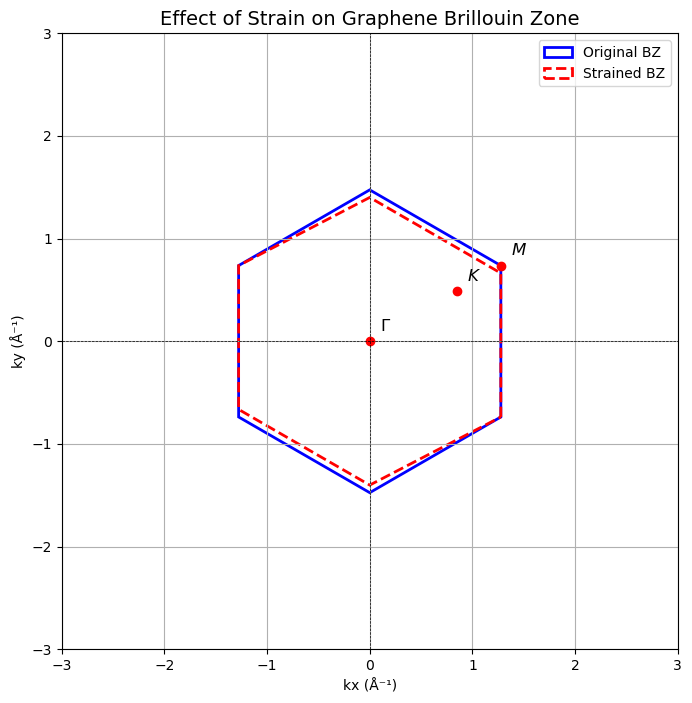

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

def graphene_reciprocal_lattice(a=2.46):
    """Calculate the reciprocal lattice vectors for graphene."""
    b1 = 2 * np.pi / a * np.array([1, -1 / np.sqrt(3), 0])
    b2 = 2 * np.pi / a * np.array([0, 2 / np.sqrt(3), 0])
    return np.array([b1, b2])

def apply_strain_to_reciprocal_lattice(b_vectors, strain_x=0.0, strain_y=0.0):
    """Apply independent strain along x and y axes to reciprocal lattice vectors."""
    b1, b2 = b_vectors
    b1_strained = np.array([b1[0] * (1 - strain_x), b1[1], b1[2]])  # Scale x-component of b1
    b2_strained = np.array([b2[0], b2[1] * (1 - strain_y), b2[2]])  # Scale y-component of b2
    return np.array([b1_strained, b2_strained])

def plot_brillouin_zone_with_strain(strain_x=0.0, strain_y=0.0):
    """Plot original and strained Brillouin zones of graphene with independent x and y strain."""
    a = 2.46  # Lattice constant in Å
    original_vectors = graphene_reciprocal_lattice(a)
    strained_vectors = apply_strain_to_reciprocal_lattice(original_vectors, strain_x, strain_y)

    # Extract 2D components (kx, ky) by dropping the z-component
    def project_to_2d(vecs):
        return vecs[:, :2]

    original_vectors_2d = project_to_2d(original_vectors)
    strained_vectors_2d = project_to_2d(strained_vectors)

    # Calculate vertices for original and strained Brillouin zones
    def calculate_vertices(b1, b2):
        return np.array([
            0.5 * b1,
            0.5 * b1 + 0.5 * b2,
            0.5 * b2,
            -0.5 * b1,
            -0.5 * b1 - 0.5 * b2,
            -0.5 * b2,
            0.5 * b1
        ])

    original_vertices = calculate_vertices(*original_vectors_2d)
    strained_vertices = calculate_vertices(*strained_vectors_2d)

    # Plot the Brillouin zones
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot original Brillouin zone
    original_polygon = Polygon(original_vertices, closed=True, edgecolor='blue', fill=False, linewidth=2, label="Original BZ")
    ax.add_patch(original_polygon)

    # Plot strained Brillouin zone
    strained_polygon = Polygon(strained_vertices, closed=True, edgecolor='red', fill=False, linewidth=2, linestyle='--', label="Strained BZ")
    ax.add_patch(strained_polygon)

    # Plot high-symmetry points (for the original BZ only)
    high_symmetry_points = {
        r"$\Gamma$": [0, 0],
        r"$K$": (1 * original_vectors_2d[0] + original_vectors_2d[1]) / 3,
        r"$M$": (original_vectors_2d[0] + original_vectors_2d[1]) / 2
    }
#                   'G': [0, 0, 0],
#                   'A': [0, 0, 1 / 2],
#                   'H': [1 / 3, 1 / 3, 1 / 2],
#                   'K': [1 / 3, 1 / 3, 0],
#                   'L': [1 / 2, 0, 1 / 2],
#                   'M': [1 / 2, 0, 0]}}
    for label, coord in high_symmetry_points.items():
        ax.plot(coord[0], coord[1], 'ro')  # Mark point
        ax.text(coord[0] + 0.1, coord[1] + 0.1, label, fontsize=12)

    # Formatting
    ax.axhline(0, color='k', linewidth=0.5, linestyle='--')
    ax.axvline(0, color='k', linewidth=0.5, linestyle='--')
    ax.set_aspect('equal')
    ax.set_xlim([-3, 3])
    ax.set_ylim([-3, 3])
    ax.set_title('Effect of Strain on Graphene Brillouin Zone', fontsize=14)
    ax.legend()
    plt.xlabel('kx (Å⁻¹)')
    plt.ylabel('ky (Å⁻¹)')
    plt.grid(True)
    plt.show()

# Example: Apply separate strains
plot_brillouin_zone_with_strain(strain_x=0.00, strain_y=0.05)


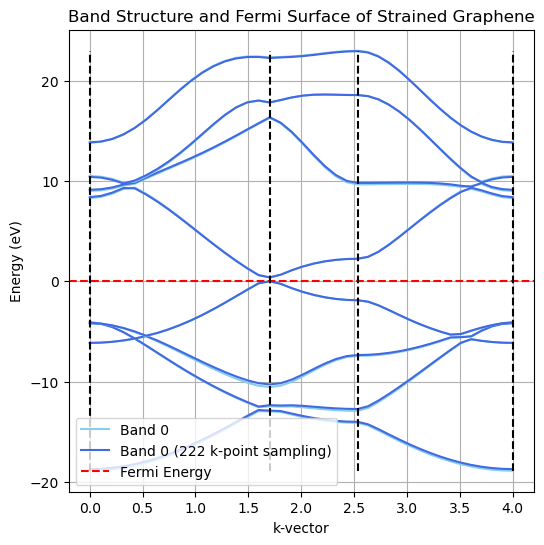

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Define the k-points and band structure for strained graphene (your calculation)
# e_kn, kpath, and sp_points should be already computed from your previous code

# Convert energies to eV
au2ev = 27.21139
e_kn_ev = np.array(e_kn) * au2ev
e_kn_2_ev = np.array(e_kn_2) * au2ev

# Define Fermi energy (example: Fermi energy can be chosen from the midpoint of the valence and conduction bands)
fermi_energy = 0.0  # You can set it based on the band structure

# Plot Fermi surface in k-space
plt.figure(figsize=(6, 6))

# Iterate through the bands and plot the contour where energy == Fermi energy
for i in range(e_kn_ev.shape[1]):  # Loop over bands
    plt.plot(kpath, e_kn_ev[:, i], color='#87CEEB', label=f'Band {i}' if i == 0 else "")
    plt.plot(kpath, e_kn_2_ev[:, i], color='#4169E1', label=f'Band {i} (222 k-point sampling)' if i == 0 else "")

# Highlight the Fermi level
plt.axhline(fermi_energy, color='red', linestyle='--', label="Fermi Energy")

# Plot the high-symmetry points (Γ, K, M)
for p in sp_points:
    plt.plot([p, p], [min(e_kn_ev.flatten()), max(e_kn_ev.flatten())], 'k--')

# Set plot labels and title
plt.xlabel('k-vector')
plt.ylabel('Energy (eV)')
plt.title('Band Structure and Fermi Surface of Strained Graphene')
plt.legend()
plt.grid(True)
plt.show()
